In [31]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.utils import save_image
from PIL import Image
import os
import torch.nn.functional as F
import numpy as np
import pandas as pd
import math as math
import matplotlib.pyplot as plt

In [32]:
# Data Loading
DATA_PATH = "data/"

# Data & Augmentation
IMAGE_SIZE = 64
STATS = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

# Model
LATENT_SIZE = 128
MODEL_VERSION = "v1"
OLD_MODEL_EXISTS = False

# Training
NUM_IMAGES_TO_USE = 1000
START_INDEX = 0
BATCH_SIZE = 100
NUM_EPOCHS = 200
LEARNING_RATE = 0.0002

# Saving/Loading Model
MODEL_PATH = "model/" + MODEL_VERSION + "/"
SAMPLE_DIR = "generated/" + MODEL_VERSION + "/"

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

Using device cpu


In [34]:
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(SAMPLE_DIR, exist_ok=True)

In [35]:
def pil_loader_rgba(path: str) -> Image.Image:
    with open(path, 'rb') as f:
        img = Image.open(f)
        background = Image.new("RGBA", img.size, "WHITE")
        alphaComposite = Image.alpha_composite(background, img)
        result = alphaComposite.convert("RGB")
        return result

In [36]:
real_dataset = torchvision.datasets.ImageFolder(root=DATA_PATH, transform=T.Compose([T.Resize(IMAGE_SIZE), 
T.CenterCrop(IMAGE_SIZE),
T.ToTensor(),
T.Normalize(*STATS)]))

real_dataset = Subset(real_dataset, range(NUM_IMAGES_TO_USE))

real_dataloader = DataLoader(real_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [37]:
def denormalize(img_tensors):
    return img_tensors *  STATS[1][0] + STATS[0][0]

def show_images(images, nmax=16):
    plt.figure()
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denormalize(images.detach()[:nmax]), nrow=8).permute(1,2,0))
    plt.show()

def show_batch(dl, nmax=16):
    for i, (images, _) in enumerate(dl):
        print(images.shape)
        show_images(images, nmax)
        break

torch.Size([100, 3, 64, 64])


<Figure size 432x288 with 0 Axes>

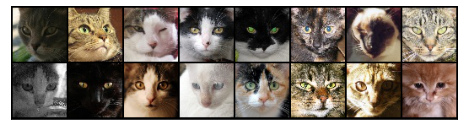

In [38]:
show_batch(real_dataloader)

In [39]:
discriminator = nn.Sequential(
    # in:  3 x 64 x 64

    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # 64 x 32 x 32

    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # 128 x 16 x 16

    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # 256 x 8 x 8

    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # 512 x 4 x 4

    nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
    # 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
).to(device)

In [40]:
generator = nn.Sequential(
    # in: LATENT_SIZE x 1 x 1

    nn.ConvTranspose2d(in_channels=LATENT_SIZE, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # 512 x 4 x 4

    nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # 256 x 8 x 8

    nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # 128 x 16 x 16

    nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # 64 x 32 x 32

    nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
    # 3 x 64 x 64
    nn.Tanh()
).to(device)

torch.Size([100, 3, 64, 64])


<Figure size 432x288 with 0 Axes>

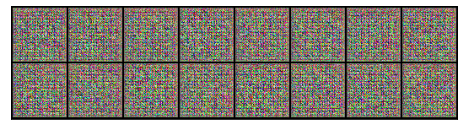

In [41]:
xb = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [42]:
def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()

    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
    fake_images = generator(latent)

    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()

    return loss.item(), real_score, fake_score

In [43]:
def train_generator(opt_g):
    opt_g.zero_grad()

    latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
    fake_images = generator(latent)

    preds = discriminator(fake_images)
    targets = torch.ones(BATCH_SIZE, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    loss.backward()
    opt_g.step()

    return loss.item()

In [44]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = "generated-image-{0:0=4d}.png".format(index)
    save_image(denormalize(fake_images), os.path.join(SAMPLE_DIR, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show and (index % 10 == 0):
       show_images(fake_images)

Saving generated-image-0000.png


<Figure size 432x288 with 0 Axes>

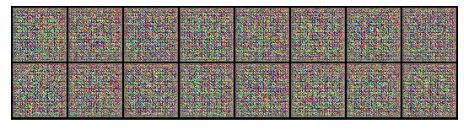

In [45]:
fixed_latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
save_samples(0, fixed_latent)

Epoch [1/200], Batch [1/10], loss_g: 2.7126, loss_d: 1.4703
Epoch [1/200], Batch [2/10], loss_g: 3.0156, loss_d: 1.2134
Epoch [1/200], Batch [3/10], loss_g: 3.3202, loss_d: 1.0163
Epoch [1/200], Batch [4/10], loss_g: 4.1334, loss_d: 0.8907
Epoch [1/200], Batch [5/10], loss_g: 4.3220, loss_d: 0.7112
Epoch [1/200], Batch [6/10], loss_g: 5.0493, loss_d: 0.8156
Epoch [1/200], Batch [7/10], loss_g: 5.6523, loss_d: 0.6094
Epoch [1/200], Batch [8/10], loss_g: 5.9292, loss_d: 0.5881
Epoch [1/200], Batch [9/10], loss_g: 6.4517, loss_d: 0.5410
Epoch [1/200], Batch [10/10], loss_g: 6.9728, loss_d: 0.4572
Saving generated-image-0001.png
Epoch [2/200], Batch [1/10], loss_g: 7.6762, loss_d: 0.4771
Epoch [2/200], Batch [2/10], loss_g: 6.8716, loss_d: 0.3200
Epoch [2/200], Batch [3/10], loss_g: 8.5658, loss_d: 0.6204
Epoch [2/200], Batch [4/10], loss_g: 6.5593, loss_d: 0.3303
Epoch [2/200], Batch [5/10], loss_g: 9.3137, loss_d: 0.5467
Epoch [2/200], Batch [6/10], loss_g: 8.5324, loss_d: 0.1860
Epoch [

<Figure size 432x288 with 0 Axes>

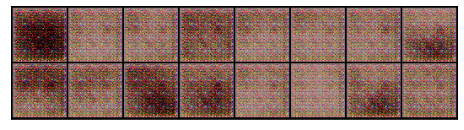

Epoch [11/200], Batch [1/10], loss_g: 6.6146, loss_d: 0.3817
Epoch [11/200], Batch [2/10], loss_g: 6.1771, loss_d: 0.1085
Epoch [11/200], Batch [3/10], loss_g: 5.9363, loss_d: 0.2479
Epoch [11/200], Batch [4/10], loss_g: 6.0096, loss_d: 0.2636
Epoch [11/200], Batch [5/10], loss_g: 7.7291, loss_d: 0.3489
Epoch [11/200], Batch [6/10], loss_g: 2.0392, loss_d: 0.4067
Epoch [11/200], Batch [7/10], loss_g: 13.6861, loss_d: 2.2442
Epoch [11/200], Batch [8/10], loss_g: 6.8365, loss_d: 5.3804
Epoch [11/200], Batch [9/10], loss_g: 3.1844, loss_d: 0.5920
Epoch [11/200], Batch [10/10], loss_g: 2.0783, loss_d: 0.3139
Saving generated-image-0011.png
Epoch [12/200], Batch [1/10], loss_g: 3.6125, loss_d: 0.6252
Epoch [12/200], Batch [2/10], loss_g: 4.0808, loss_d: 0.2561
Epoch [12/200], Batch [3/10], loss_g: 3.5186, loss_d: 0.3101
Epoch [12/200], Batch [4/10], loss_g: 3.3637, loss_d: 0.3647
Epoch [12/200], Batch [5/10], loss_g: 3.9194, loss_d: 0.4540
Epoch [12/200], Batch [6/10], loss_g: 3.3242, loss_

<Figure size 432x288 with 0 Axes>

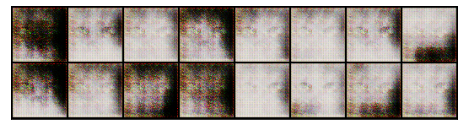

Epoch [21/200], Batch [1/10], loss_g: 4.8971, loss_d: 0.2498
Epoch [21/200], Batch [2/10], loss_g: 3.2790, loss_d: 0.2261
Epoch [21/200], Batch [3/10], loss_g: 5.9805, loss_d: 0.4551
Epoch [21/200], Batch [4/10], loss_g: 5.2583, loss_d: 0.3606
Epoch [21/200], Batch [5/10], loss_g: 3.9532, loss_d: 0.2720
Epoch [21/200], Batch [6/10], loss_g: 4.3995, loss_d: 0.2103
Epoch [21/200], Batch [7/10], loss_g: 4.3986, loss_d: 0.1556
Epoch [21/200], Batch [8/10], loss_g: 4.4925, loss_d: 0.1795
Epoch [21/200], Batch [9/10], loss_g: 4.6939, loss_d: 0.3125
Epoch [21/200], Batch [10/10], loss_g: 4.6177, loss_d: 0.4926
Saving generated-image-0021.png
Epoch [22/200], Batch [1/10], loss_g: 4.2215, loss_d: 0.3535
Epoch [22/200], Batch [2/10], loss_g: 5.8624, loss_d: 0.3911
Epoch [22/200], Batch [3/10], loss_g: 3.3155, loss_d: 0.6162
Epoch [22/200], Batch [4/10], loss_g: 8.5412, loss_d: 1.2943
Epoch [22/200], Batch [5/10], loss_g: 4.3771, loss_d: 1.7240
Epoch [22/200], Batch [6/10], loss_g: 3.8693, loss_d

<Figure size 432x288 with 0 Axes>

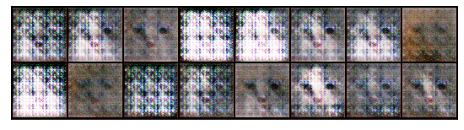

Epoch [31/200], Batch [1/10], loss_g: 6.4756, loss_d: 0.4094
Epoch [31/200], Batch [2/10], loss_g: 2.8283, loss_d: 0.5380
Epoch [31/200], Batch [3/10], loss_g: 11.1737, loss_d: 2.4100
Epoch [31/200], Batch [4/10], loss_g: 6.0572, loss_d: 4.9070
Epoch [31/200], Batch [5/10], loss_g: 2.0473, loss_d: 0.3651
Epoch [31/200], Batch [6/10], loss_g: 3.1556, loss_d: 1.1813
Epoch [31/200], Batch [7/10], loss_g: 3.8329, loss_d: 0.4841
Epoch [31/200], Batch [8/10], loss_g: 2.6884, loss_d: 0.7377
Epoch [31/200], Batch [9/10], loss_g: 3.5912, loss_d: 0.8143
Epoch [31/200], Batch [10/10], loss_g: 3.0331, loss_d: 0.5333
Saving generated-image-0031.png
Epoch [32/200], Batch [1/10], loss_g: 2.7768, loss_d: 0.5925
Epoch [32/200], Batch [2/10], loss_g: 3.2818, loss_d: 0.6661
Epoch [32/200], Batch [3/10], loss_g: 2.9854, loss_d: 0.7100
Epoch [32/200], Batch [4/10], loss_g: 3.5845, loss_d: 0.8784
Epoch [32/200], Batch [5/10], loss_g: 2.3081, loss_d: 0.8873
Epoch [32/200], Batch [6/10], loss_g: 5.2296, loss_

<Figure size 432x288 with 0 Axes>

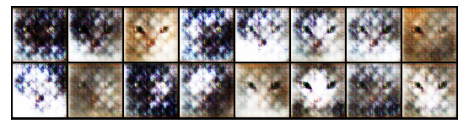

Epoch [41/200], Batch [1/10], loss_g: 7.8423, loss_d: 0.9420
Epoch [41/200], Batch [2/10], loss_g: 4.4655, loss_d: 1.3792
Epoch [41/200], Batch [3/10], loss_g: 2.8522, loss_d: 0.3037
Epoch [41/200], Batch [4/10], loss_g: 6.9159, loss_d: 0.8286
Epoch [41/200], Batch [5/10], loss_g: 4.7714, loss_d: 0.7124
Epoch [41/200], Batch [6/10], loss_g: 2.8769, loss_d: 0.3790
Epoch [41/200], Batch [7/10], loss_g: 6.2511, loss_d: 0.9126
Epoch [41/200], Batch [8/10], loss_g: 3.8458, loss_d: 1.0186
Epoch [41/200], Batch [9/10], loss_g: 2.9122, loss_d: 0.3692
Epoch [41/200], Batch [10/10], loss_g: 5.7213, loss_d: 0.6043
Saving generated-image-0041.png
Epoch [42/200], Batch [1/10], loss_g: 4.1017, loss_d: 0.4479
Epoch [42/200], Batch [2/10], loss_g: 3.4681, loss_d: 0.3317
Epoch [42/200], Batch [3/10], loss_g: 6.2545, loss_d: 0.5784
Epoch [42/200], Batch [4/10], loss_g: 3.7810, loss_d: 0.7109
Epoch [42/200], Batch [5/10], loss_g: 4.4937, loss_d: 0.4219
Epoch [42/200], Batch [6/10], loss_g: 4.7391, loss_d

<Figure size 432x288 with 0 Axes>

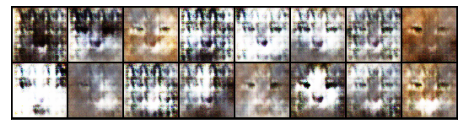

Epoch [51/200], Batch [1/10], loss_g: 5.5707, loss_d: 0.4800
Epoch [51/200], Batch [2/10], loss_g: 4.2829, loss_d: 0.3782
Epoch [51/200], Batch [3/10], loss_g: 3.5928, loss_d: 0.5040
Epoch [51/200], Batch [4/10], loss_g: 4.5120, loss_d: 0.5671
Epoch [51/200], Batch [5/10], loss_g: 4.3278, loss_d: 0.4989
Epoch [51/200], Batch [6/10], loss_g: 4.6525, loss_d: 0.6117
Epoch [51/200], Batch [7/10], loss_g: 3.1998, loss_d: 0.6196
Epoch [51/200], Batch [8/10], loss_g: 6.7626, loss_d: 0.8962
Epoch [51/200], Batch [9/10], loss_g: 4.0705, loss_d: 0.6585
Epoch [51/200], Batch [10/10], loss_g: 5.0085, loss_d: 0.6038
Saving generated-image-0051.png
Epoch [52/200], Batch [1/10], loss_g: 5.0537, loss_d: 0.3349
Epoch [52/200], Batch [2/10], loss_g: 3.2806, loss_d: 0.4626
Epoch [52/200], Batch [3/10], loss_g: 7.6852, loss_d: 0.8601
Epoch [52/200], Batch [4/10], loss_g: 3.2190, loss_d: 1.2377
Epoch [52/200], Batch [5/10], loss_g: 4.2187, loss_d: 0.5665
Epoch [52/200], Batch [6/10], loss_g: 4.2902, loss_d

<Figure size 432x288 with 0 Axes>

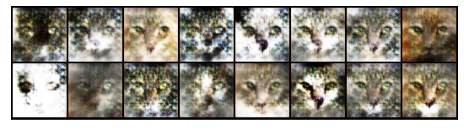

Epoch [61/200], Batch [1/10], loss_g: 4.9688, loss_d: 0.5522
Epoch [61/200], Batch [2/10], loss_g: 3.8760, loss_d: 0.3604
Epoch [61/200], Batch [3/10], loss_g: 4.2927, loss_d: 0.4002
Epoch [61/200], Batch [4/10], loss_g: 4.1388, loss_d: 0.5171
Epoch [61/200], Batch [5/10], loss_g: 5.2626, loss_d: 0.4683
Epoch [61/200], Batch [6/10], loss_g: 3.9973, loss_d: 0.3834
Epoch [61/200], Batch [7/10], loss_g: 5.2348, loss_d: 0.4341
Epoch [61/200], Batch [8/10], loss_g: 4.8981, loss_d: 0.2555
Epoch [61/200], Batch [9/10], loss_g: 4.3882, loss_d: 0.2818
Epoch [61/200], Batch [10/10], loss_g: 5.2792, loss_d: 0.4022
Saving generated-image-0061.png
Epoch [62/200], Batch [1/10], loss_g: 3.9296, loss_d: 0.2470
Epoch [62/200], Batch [2/10], loss_g: 5.2012, loss_d: 0.3028
Epoch [62/200], Batch [3/10], loss_g: 6.8067, loss_d: 0.4216
Epoch [62/200], Batch [4/10], loss_g: 0.8904, loss_d: 1.0162
Epoch [62/200], Batch [5/10], loss_g: 12.1882, loss_d: 2.5208
Epoch [62/200], Batch [6/10], loss_g: 9.5448, loss_

In [46]:
opt_d = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_g = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999)) 

if (OLD_MODEL_EXISTS):
    discriminator.load_state_dict(torch.load(MODEL_PATH + "discriminator.pt"))
    generator.load_state_dict(torch.load(MODEL_PATH + "generator.pt"))

for epoch in range(NUM_EPOCHS):
    num_batches = len(real_dataloader)
    
    for batch_number, (real_images, _) in enumerate(real_dataloader):
        loss_d, _, _ = train_discriminator(real_images, opt_d)
        loss_g = train_generator(opt_g)
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Batch [{batch_number+1}/{num_batches}], loss_g: {loss_g:.4f}, loss_d: {loss_d:.4f}")
        
    save_samples(epoch+1+START_INDEX, fixed_latent, show=True)
    torch.save(discriminator.state_dict(), MODEL_PATH + "discriminator.pt")
    torch.save(generator.state_dict(), MODEL_PATH + "generator.pt")


In [ ]:
torch.save(discriminator.state_dict(), MODEL_PATH + "discriminator.pt")
torch.save(generator.state_dict(), MODEL_PATH + "generator.pt")

In [ ]:
discriminator.load_state_dict(torch.load(MODEL_PATH + "discriminator.pt"))
generator.load_state_dict(torch.load(MODEL_PATH + "generator.pt"))

<All keys matched successfully>